# Description

Scenario :
* 1 receptor
* Docking experiment with a set of active ligands and decoys
* Rescoring of the poses

Requirements :
* Have "ligands" in the mol2 filename of your active molecules, and "decoys" for the others
* Run DockFlow and ScoreFlow
* Fill the User Input section of this notebook
* Click on the "Cell" tab, "Run All"

Output :
* Tables
* Bar charts
* Enrichment rates
* ROC curves
* AUC

# User Input

In [1]:
# Path to data
# The notebook should be ran from the working directory folder.
# You can change the path to the summary folder here.
# Default : path = "."
path = "."

In [2]:
# Save folder for tables and graphs
# By default, the save folder will be created inside the work directory
# as "ReportFlow/PLANTS_VS_decoys_enrichment"
# You can change the path and names of the save folder here.
# Default : save_folder = "./PLANTS_docking_rescoring_decoys_actives"
save_folder = "./PLANTS_docking_rescoring_decoys_actives"

# Initialization

In [3]:
# Only show output, hide code.
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
# Import python modules

%matplotlib inline

from matplotlib import rcParams
rcParams['mathtext.default'] = 'tt'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
from sklearn.metrics import auc
import os.path

## Process user input

In [5]:
# Create a list of ligands based on folder name
dockfile_list = ! ls -l {path}/docking/ | awk '/^d/{{print $$9}}'

In [6]:
# Create the save folder
! mkdir -p $save_folder

In [7]:
# Check results available
method_list = []
scores_list = []

# Docking
f = '{}/docking/ranking_sorted.csv'.format(path)
if os.path.isfile(f):  
    scores_list.append('PLANTS')
    # Rescoring
    rescoring_folders = ! ls -l {path}/rescoring/ | awk '/^d/{{print $$9}}'
    # check for the ranking.csv files
    for method in rescoring_folders:
        f = '{}/rescoring/{}/ranking.csv'.format(path,method)
        if os.path.isfile(f):
            if method not in method_list:
                method_list.append(method)
                scores_list.append(method.upper())
        else:
            print("ERROR : {} does not contain the ranking.csv file".format(method))

    print('Results detected : {}'.format(' - '.join(scores_list)))
    
# if docking results don't exist    
else:
    print("ERROR : {}/docking does not contain the ranking_sorted.csv file".format(path))

Results detected : PLANTS - GB8_1F - GB8_MD - PLP - VINA


## Create Dataframes

In [8]:
# PLANTS docking results
f = '{}/docking/ranking_sorted.csv'.format(path)
plants_detail = pd.read_csv(f, header=0)
plants_detail.rename(columns = {'TOTAL_SCORE' : 'PLANTS', 'LIGAND_ENTRY' : 'POSE'}, inplace=True)

# Assign ligand name by splitting the pose name
plants_detail = plants_detail.assign(LIGAND = plants_detail.POSE.apply(lambda x: x.split('_')[0]))
# Add rank
plants_detail.reset_index(inplace=True)
plants_detail.rename(columns = {'index' : 'PLANTS_RANK'}, inplace=True)

# Add description
for dockfile in dockfile_list:
    ligand_list = ! cd {path}/docking/{dockfile}/; ls *.mol2 | cut -d"_" -f1 | uniq | sed s/.mol2//g
    for ligand in ligand_list:
        if 'decoys' in dockfile:
            description = 'decoy'
        elif 'ligands' in dockfile:
            description = 'active'
        else:
            description = 'unknown'
        plants_detail.loc[plants_detail['LIGAND'] == ligand, 'DESCRIPTION'] = description
    
plants = plants_detail[['LIGAND','POSE','DESCRIPTION','PLANTS_RANK','PLANTS']]

In [9]:
# Create actual ligand list
lig_list = plants['LIGAND'].unique().tolist()

In [11]:
# Rescoring results

# Create a dictionnary that will store all data
rescoring = {}
rescoring_detail = {}
rescoring_decomp = {}

for method in method_list:
    f = '{}/rescoring/{}/ranking.csv'.format(path,method)
    
    # VINA results
    if "vina" in method:
        rescoring_detail[method] = pd.read_csv(f, header=0)
        rescoring_detail[method].rename(columns = {'Affinity' : method.upper(), 'Ligand' : 'POSE'}, inplace=True)
        # Sort and add rank
        rescoring_detail[method].sort_values(method.upper(), inplace=True)
        rescoring_detail[method].reset_index(inplace=True, drop=True)
        rescoring_detail[method].reset_index(inplace=True)
        rank = '{}_RANK'.format(method.upper())
        rescoring_detail[method].rename(columns = {'index' : rank}, inplace=True)
        rescoring[method] = rescoring_detail[method][['POSE',rank, method.upper()]]
    
    # PLANTS results
    elif 'plp' in method:
        rescoring_detail[method] = pd.read_csv(f, header=0)
        rescoring_detail[method].rename(columns = {'TOTAL_SCORE' : method.upper(), 'LIGAND_ENTRY' : 'POSE'}, inplace=True)
        # Sort and add rank
        rescoring_detail[method].sort_values(method.upper(), inplace=True)
        rescoring_detail[method].reset_index(inplace=True, drop=True)
        rescoring_detail[method].reset_index(inplace=True)
        rank = '{}_RANK'.format(method.upper())
        rescoring_detail[method].rename(columns = {'index' : rank}, inplace=True)
        rescoring[method] = rescoring_detail[method][['POSE',rank, method.upper()]]

    # MM-PB/GB-SA results
    elif any(x in method for x in ['PB','GB']):
        # If mmpbsa was based on MD simulation
        MDfile = '{}/rescoring/{}/MD_prod.csv'.format(path,method)
        if os.path.isfile(MDfile):
            # Full dataframe with time series of ligand, receptor, complex and delta
            rescoring_decomp[method] = pd.read_csv(f, header=0)
            rescoring_decomp[method].rename(columns = {'TOTAL' : method.upper(), 'Ligand' : 'POSE'}, inplace=True)
            # Keep only the 'DELTA' term
            rescoring_detail[method] = rescoring_decomp[method].loc[rescoring_decomp[method]['Structure'] == 'DELTA']
            rescoring_detail[method] = rescoring_detail[method].drop('Structure', axis=1)
            rescoring_detail[method].reset_index(inplace=True, drop=True)
            # Keep only the average of each term, sort and add rank
            rescoring[method] = pd.DataFrame()
            for pose in rescoring_detail[method]['POSE'].unique():
                # Locate data for each pose
                sliced = rescoring_detail[method].loc[rescoring_detail[method]['POSE'] == pose]
                # Compute mean and standard error of mean
                mean = sliced[method].mean()
                error = sliced[method].sem()
                error_col = '{}_ERROR'.format(method.upper())
                # Create a temporary dataframe containing pose, mean and error
                temp = pd.DataFrame([pose, mean, error], index=['POSE', method, error_col]).transpose()
                rescoring[method] = pd.concat([rescoring[method],temp])
            # Sort and copy index to create the rank
            rescoring[method] = rescoring[method].sort_values(method.upper())
            rescoring[method].reset_index(inplace=True, drop=True)
            rescoring[method].reset_index(inplace=True)
            rank = '{}_RANK'.format(method.upper())
            rescoring[method].rename(columns = {'index' : rank}, inplace=True)
            # Reorganize the order
            error = '{}_ERROR'.format(method.upper())
            rescoring[method] = rescoring[method][['POSE',rank, method.upper(),error]]
        
        else:
            rescoring_decomp[method] = pd.read_csv(f, header=0)
            rescoring_detail[method] = rescoring_decomp[method].loc[rescoring_decomp[method]['Structure'] == 'DELTA']
            rescoring_detail[method] = rescoring_detail[method].drop('Structure', axis=1)
            rescoring_detail[method].rename(columns = {'TOTAL' : method.upper(), 'Ligand' : 'POSE'}, inplace=True)
            # Sort and add rank
            rescoring_detail[method].sort_values(method.upper(), inplace=True)
            rescoring_detail[method].reset_index(inplace=True, drop=True)
            rescoring_detail[method].reset_index(inplace=True)
            rank = '{}_RANK'.format(method.upper())
            rescoring_detail[method].rename(columns = {'index' : rank}, inplace=True)
            rescoring[method] = rescoring_detail[method][['POSE',rank, method.upper()]]

In [12]:
# Match all results

# PLANTS
all_scores = plants.copy()

# RESCORING
for method in method_list:
    all_scores = pd.merge(all_scores, rescoring[method], how='left', on=['POSE'] )
    
# only poses with values
all_subset = all_scores.dropna()

In [13]:
# actives and decoys
actives = all_scores.loc[all_scores['DESCRIPTION'] == 'active']
# keep only poses with values
actives_subset = actives.dropna()

In [14]:
# Melted dataframes

# for score
df_scores = pd.melt(all_scores, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=scores_list, var_name='METHOD', value_name='SCORE')
# for rank
df_rank = pd.melt(all_scores, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['{}_RANK'.format(i) for i in scores_list], var_name='METHOD', value_name='RANK')
# rename method to remove "_RANK"
df_rank['METHOD'] = df_rank['METHOD'].apply(lambda x: x.split('_RANK')[0])
df = pd.merge(df_scores, df_rank, how='left', on=['LIGAND','POSE','DESCRIPTION','METHOD'])

# subset only keeping poses with values
# for score
df_scores_subset = pd.melt(all_subset, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=scores_list, var_name='METHOD', value_name='SCORE')
# for rank
df_rank_subset = pd.melt(all_subset, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['{}_RANK'.format(i) for i in scores_list], var_name='METHOD', value_name='RANK')
# rename method to remove "_RANK"
df_rank_subset['METHOD'] = df_rank_subset['METHOD'].apply(lambda x: x.split('_RANK')[0])
df_subset = pd.merge(df_scores_subset, df_rank_subset, how='left', on=['LIGAND','POSE','DESCRIPTION','METHOD'])

In [15]:
# Enrichment factor

temp = []
nb_actives_total = len(actives_subset)
nb_compounds_total = len(all_subset)
for method in scores_list:
    for perc in np.arange(0, 100.5, 0.5):
        x = int(perc*nb_compounds_total/100)
        t = all_subset.sort_values(method).head(x)
        nb_actives_x = len(t.loc[t['DESCRIPTION'] == 'active'])
        nb_compounds_x = len(t)
        try:
            efactor = (nb_actives_x * nb_compounds_total) / (nb_compounds_x * nb_actives_total)
        except ZeroDivisionError:
            efactor = np.NaN
        finally:
            temp.append([perc,x,efactor,method])
EF = pd.DataFrame(temp, columns=['Percentage','Nb of compounds selected', 'Enrichment Factor','METHOD'])

In [16]:
# ROC

temp = []

# number of positives and negatives in dataset
p = len(all_subset.loc[all_subset['DESCRIPTION'] == 'active'])
n = len(all_subset.loc[all_subset['DESCRIPTION'] == 'decoy'])

for method in scores_list:
    for fraction in np.arange(0.01, 1.01, 0.01):
        # convert fraction to an integer for range selection
        x = int(fraction*len(all_subset))
        # dataset containing fraction of positives
        pos = all_subset.sort_values(method)[:x]
        # number of true positives
        tp = len(pos.loc[pos['DESCRIPTION'] == 'active'])
        # number of false positives
        fp = len(pos.loc[pos['DESCRIPTION'] == 'decoy'])
        # rates for ROC curves
        tpr = tp/p
        fpr = fp/n
        temp.append([fraction,tpr,fpr,method])

ROC = pd.DataFrame(temp, columns=['threshold','TPR', 'FPR','METHOD'])

In [17]:
# Color palettes
# Create color palette and dictionnary based on the ligand list for the plots
color_list = sns.husl_palette(len(lig_list),0,0.8,0.65)

# Color list based on state       
state_list = ['active', 'decoy', 'unknown']
state_color_list = [sns.color_palette('deep')[1], sns.color_palette('deep')[2], sns.color_palette('deep')[0]]

# Create a hatch list for plots based on the method list
hatch_list = ['','/', '\\', '-', '.', '//']
method_hatch_list = [hatch_list[i] for i in range(len(scores_list))]
method_color_list = [[c for c in sns.color_palette("deep")][i] for i in range(len(scores_list))]

# Set the new custom color list
sns.set_palette(sns.color_palette('deep'))

# Results

## Actives Rank

In [18]:
# All actives

actives

,LIGAND,POSE,DESCRIPTION,PLANTS_RANK,PLANTS,GB8_1F_RANK,GB8_1F,GB8_MD_RANK,GB8_MD,GB8_MD_ERROR,PLP_RANK,PLP,VINA_RANK,VINA
1,ZINC03833842,ZINC03833842_entry_00043_conf_01,active,1,-116.2280,1.0,-57.625816,1.0,-51.8685,0.46569,0,-108.5580,653,-9.37315
12,ZINC03833842,ZINC03833842_entry_00043_conf_02,active,12,-112.0760,NaN,NaN,NaN,NaN,NaN,12,-104.2010,8586,-8.32851
13,ZINC03833856,ZINC03833856_entry_00057_conf_01,active,13,-112.8490,8.0,-44.766975,4.0,-36.5298,0.399945,19,-103.4940,2679,-8.85019
14,ZINC03833858,ZINC03833858_entry_00059_conf_01,active,14,-112.5680,2.0,-49.168245,3.0,-46.3161,0.576787,6,-104.8460,953,-9.23237
24,ZINC03833843,ZINC03833843_entry_00044_conf_01,active,24,-111.0080,6.0,-45.968060,6.0,-35.4813,0.518821,73,-100.4680,1288,-9.13306
34,ZINC03833856,ZINC03833856_entry_00057_conf_02,active,34,-110.2450,NaN,NaN,NaN,NaN,NaN,1,-106.3440,2,-10.87903
35,ZINC03833857,ZINC03833857_entry_00058_conf_01,active,35,-110.7550,13.0,-42.524128,11.0,-30.9104,0.408022,46,-101.8920,641,-9.37858
44,ZINC03833843,ZINC03833843_entry_00044_conf_02,active,44,-109.7820,NaN,NaN,NaN,NaN,NaN,9,-104.3330,1535,-9.07049
45,ZINC03833858,ZINC03833858_entry_00059_conf_02,active,45,-109.5950,NaN,NaN,NaN,NaN,NaN,17,-103.5450,3933,-8.69328
46,ZINC03833859,ZINC03833859_entry_00060_conf_01,active,46,-109.5960,NaN,NaN,NaN,NaN,NaN,28,-102.7830,225,-9.71008


In [19]:
print("Number of ligands in total : {}".format(len(lig_list)))
print("Number of docking poses in total : {}".format(len(all_scores)))

Number of ligands in total : 1938
Number of docking poses in total : 52500


In [20]:
# All actives with results

actives_subset

,LIGAND,POSE,DESCRIPTION,PLANTS_RANK,PLANTS,GB8_1F_RANK,GB8_1F,GB8_MD_RANK,GB8_MD,GB8_MD_ERROR,PLP_RANK,PLP,VINA_RANK,VINA
1,ZINC03833842,ZINC03833842_entry_00043_conf_01,active,1,-116.228,1.0,-57.625816,1.0,-51.8685,0.46569,0,-108.558,653,-9.37315
13,ZINC03833856,ZINC03833856_entry_00057_conf_01,active,13,-112.849,8.0,-44.766975,4.0,-36.5298,0.399945,19,-103.494,2679,-8.85019
14,ZINC03833858,ZINC03833858_entry_00059_conf_01,active,14,-112.568,2.0,-49.168245,3.0,-46.3161,0.576787,6,-104.846,953,-9.23237
24,ZINC03833843,ZINC03833843_entry_00044_conf_01,active,24,-111.008,6.0,-45.968060,6.0,-35.4813,0.518821,73,-100.468,1288,-9.13306
35,ZINC03833857,ZINC03833857_entry_00058_conf_01,active,35,-110.755,13.0,-42.524128,11.0,-30.9104,0.408022,46,-101.892,641,-9.37858


In [21]:
print("Number of docking poses in subset : {}".format(len(all_subset)))

Number of docking poses in subset : 22


## Summary

In [22]:
all_scores.describe()

,PLANTS_RANK,PLANTS,GB8_1F_RANK,GB8_1F,GB8_MD_RANK,PLP_RANK,PLP,VINA_RANK,VINA
count,52500.000000,52500.000000,22.000000,22.000000,22.000000,52500.000000,52500.000000,52500.000000,52500.000000
mean,26249.500000,-74.898676,10.500000,-43.221215,10.500000,26249.500000,-75.057520,26249.500000,-7.538245
std,15155.588903,11.709491,6.493587,6.962151,6.493587,15155.588903,8.778328,15155.588903,0.859091
min,0.000000,-116.492000,0.000000,-58.540668,0.000000,0.000000,-108.558000,0.000000,-11.132230
25%,13124.750000,-82.152900,5.250000,-46.815805,5.250000,13124.750000,-80.491325,13124.750000,-8.092197
50%,26249.500000,-75.420950,10.500000,-43.200900,10.500000,26249.500000,-75.397800,26249.500000,-7.576235
75%,39374.250000,-68.579375,15.750000,-38.322781,15.750000,39374.250000,-70.331800,39374.250000,-7.033120
max,52499.000000,34.083100,21.000000,-29.864575,21.000000,52499.000000,22.449900,52499.000000,1.794570


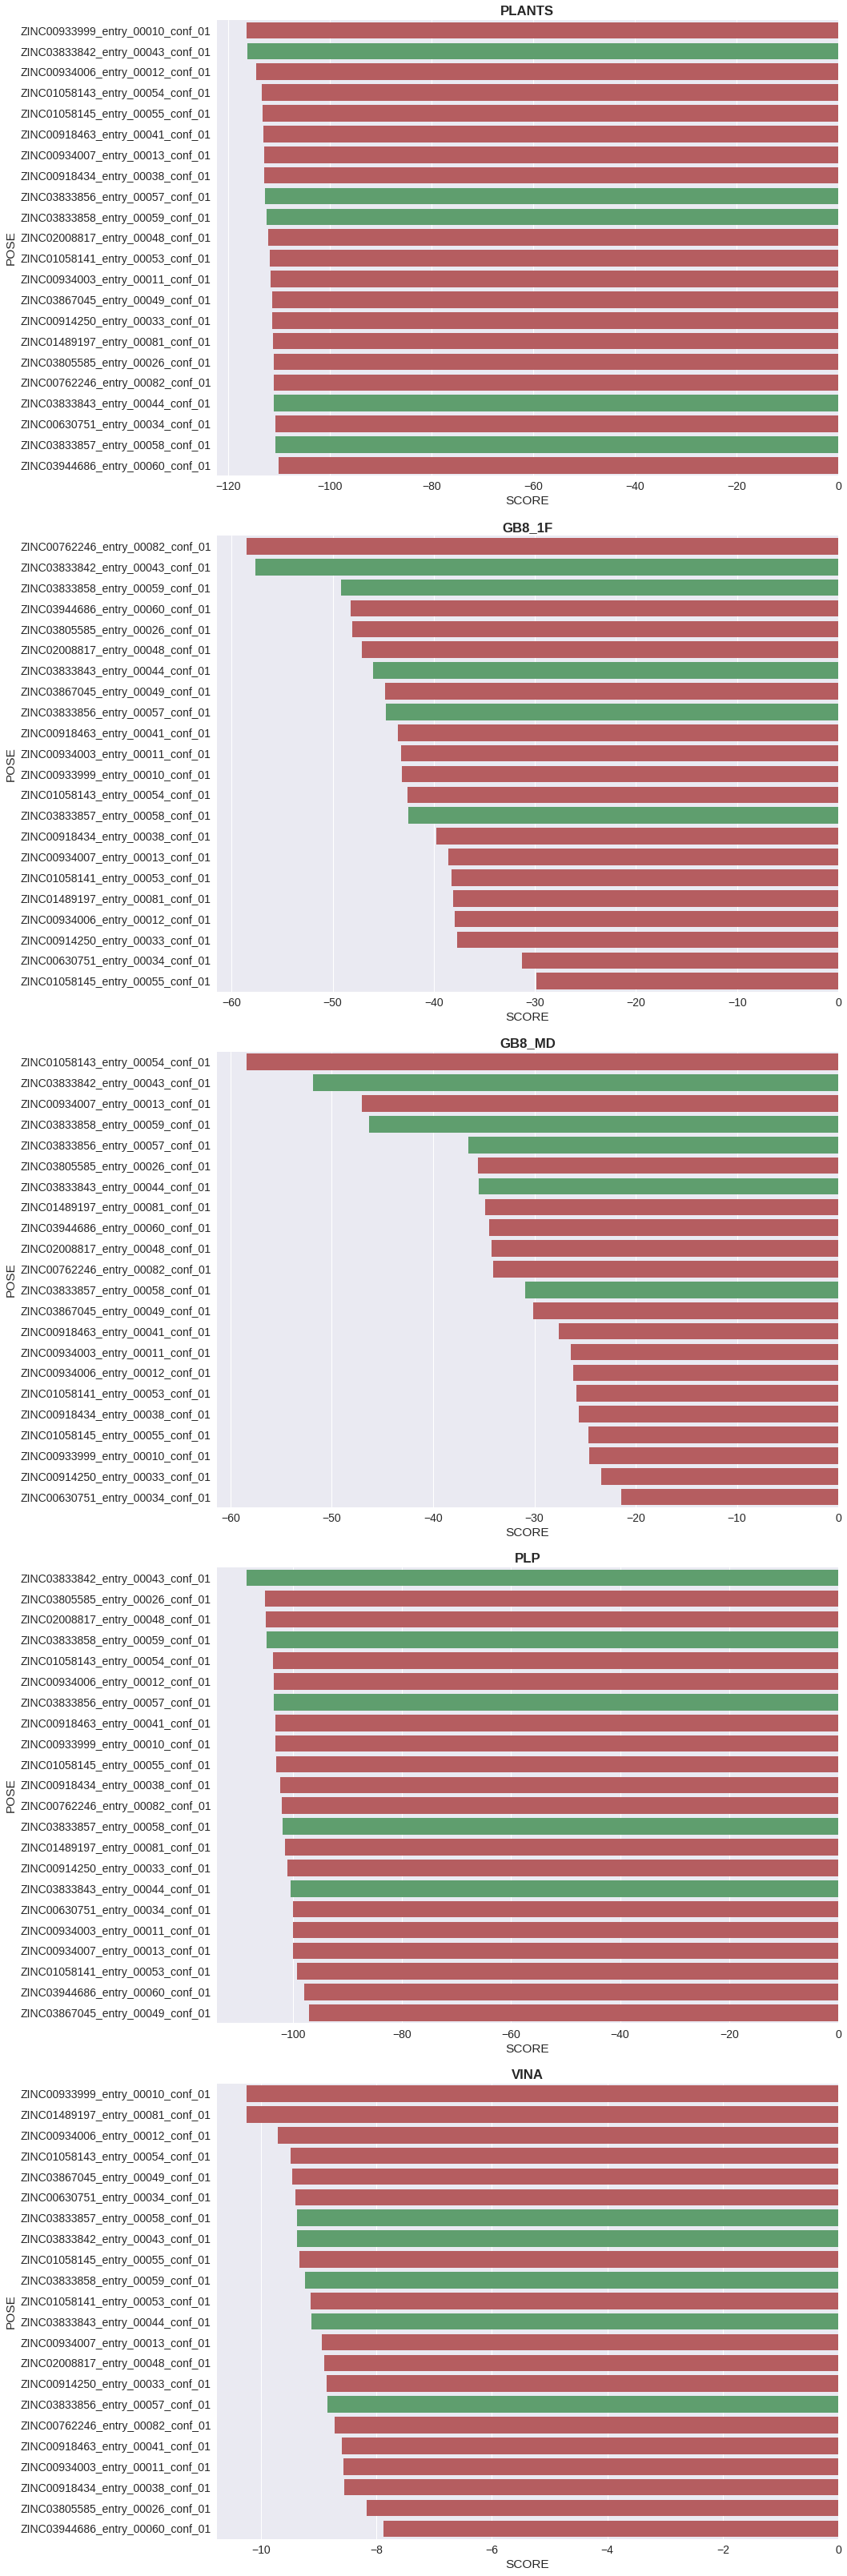

In [23]:
# Sorted barplot for each method

def grid_barplot(data,size=15,aspect=3,col_wrap=1):
    aspect = aspect
    size_x = size
    size_y = size_x*aspect
    methods = data.METHOD.unique()
    num_subplots = len(methods)
    num_cols = col_wrap
    num_rows = num_subplots // num_cols
    num_rows += num_subplots % num_cols
    position = range(1, num_subplots+1)

    fig = plt.figure(figsize=(size_x,size_y))
    for method,v in zip(methods, range(num_subplots)):
        data_subset = data.loc[data.METHOD == method].sort_values('SCORE')
        order = data_subset.POSE.tolist()
        colors = [state_color_list[0] if (x == 'active') else state_color_list[1] for x in data_subset.DESCRIPTION]
        ax = fig.add_subplot(num_rows,num_cols,position[v])
        sns.barplot(x=data_subset.SCORE, y=data_subset.POSE, 
                    palette=colors,
                    orient='h', order=order, ax=ax, label=method)
        ax.legend().set_visible(False)
        ax.set_title(method,fontweight='bold')
        ax.set_xlabel('SCORE')

    plt.tight_layout()

grid_barplot(data=df_subset)

## Actives versus decoys

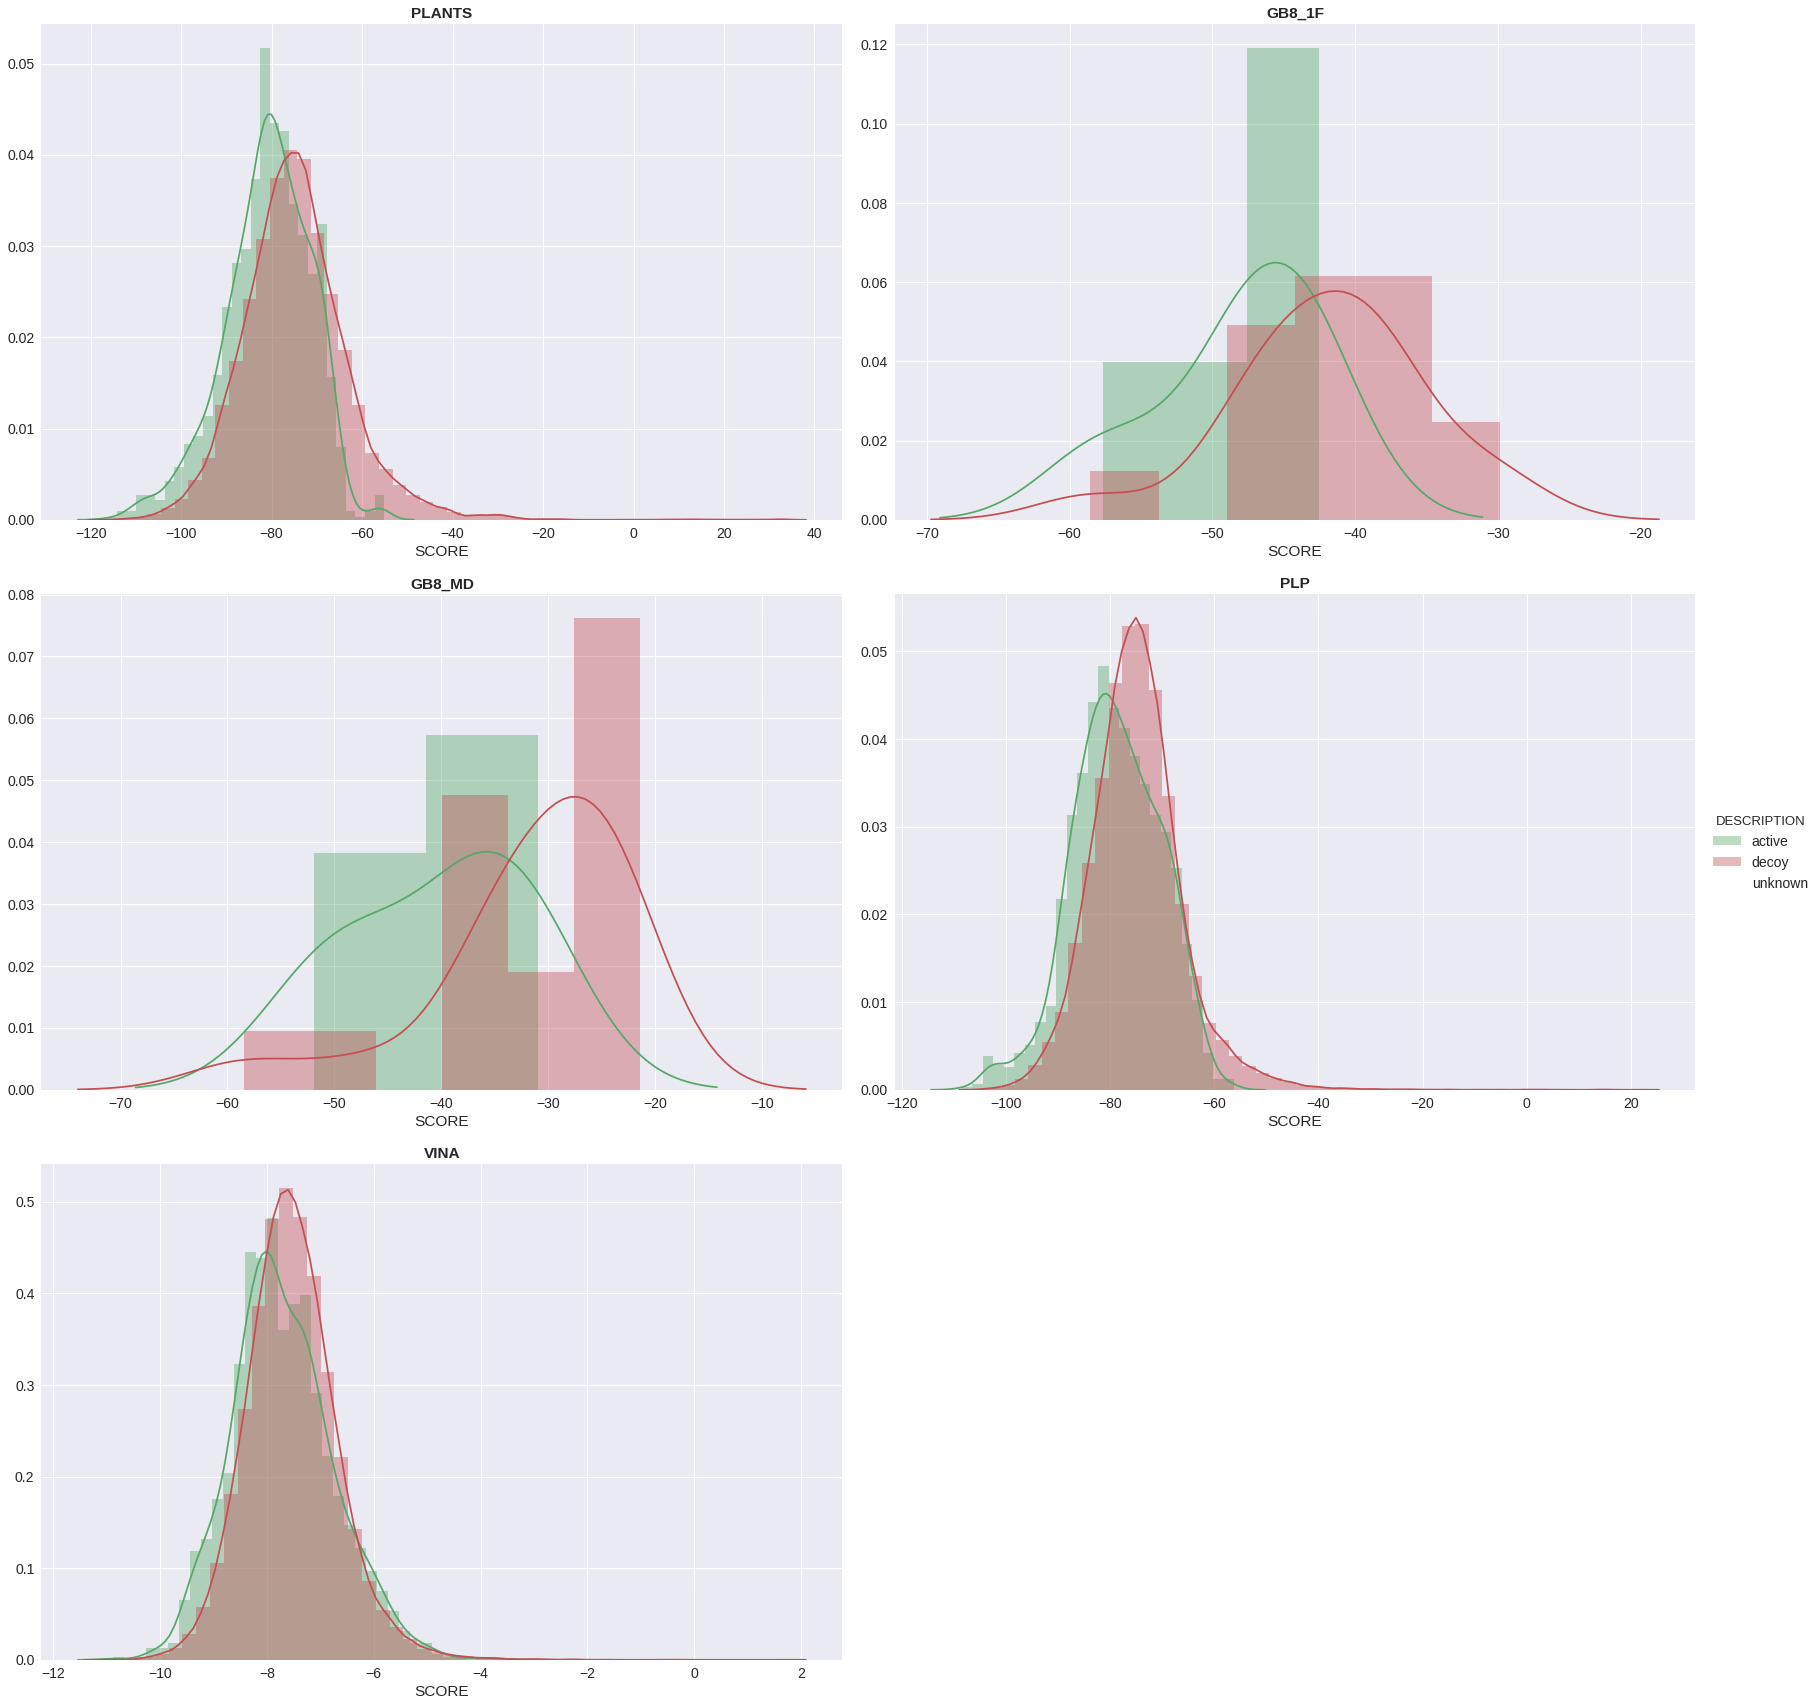

In [24]:
# KDE plot and histogram
g = sns.FacetGrid(data=df, hue='DESCRIPTION', hue_order=state_list, 
                  col='METHOD', col_wrap=2, sharex=False, sharey=False,
                  aspect=1.5, size=8, palette=state_color_list)
g.map(sns.distplot,'SCORE', kde=True)
g.add_legend()
g.set_titles('{col_name}',fontweight='bold')

plt.subplots_adjust(hspace=0.15)
for ax in g.axes.flat:
    ax.set_xlabel('SCORE', visible=True)
    
plt.savefig('{}/kde_actives_decoys.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

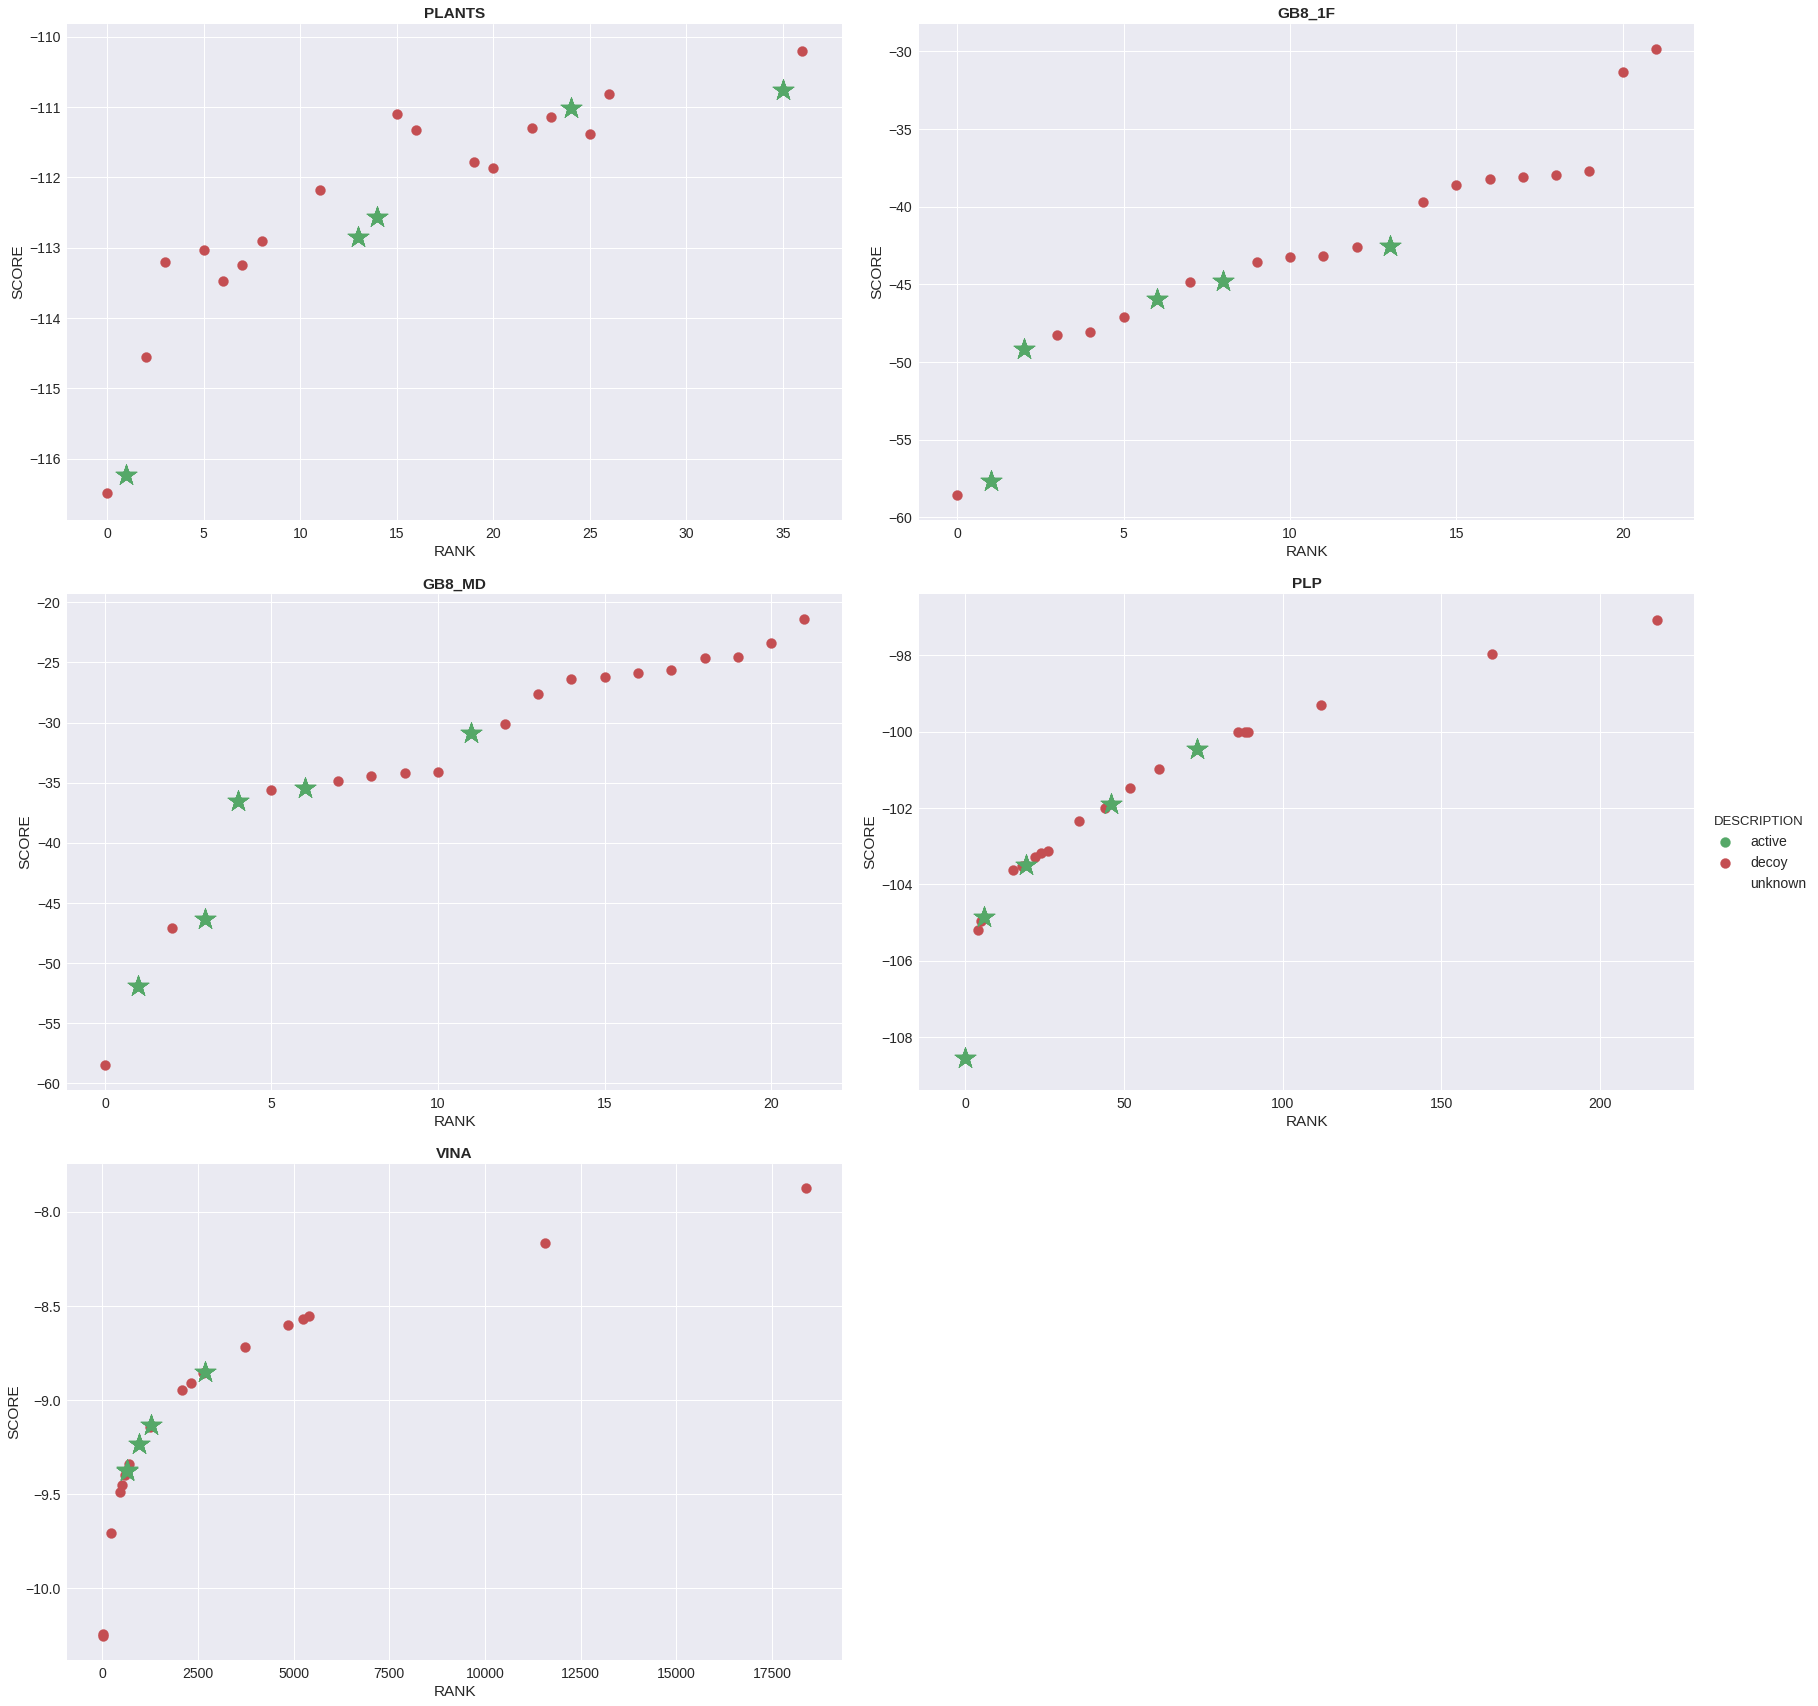

In [25]:
# Scatter plot : score by rank
g = sns.FacetGrid(data=df_subset ,hue='DESCRIPTION', hue_order=state_list, 
                  col='METHOD', col_wrap=2, sharex=False, sharey=False,
                  aspect=1.5, size=8, palette=state_color_list)

g.map(plt.scatter, 'RANK', 'SCORE', s=100)
g.add_legend()
g.set_titles('{col_name}',fontweight='bold')
plt.subplots_adjust(hspace=0.15,wspace=0.1)

for pose in df_subset['POSE']:
    temp = df_subset.loc[df_subset['POSE'] == pose]
    state = temp['DESCRIPTION'].values[0]
    if state == 'active':
        for method, ax in zip(scores_list, g.axes.flat):
            x = temp.loc[temp['METHOD'] == method]['RANK'].values[0]
            y = temp.loc[temp['METHOD'] == method]['SCORE'].values[0]
            ax.scatter(x,y,s=500,c=state_color_list[0],marker='*')
            ax.set_xlabel('RANK', visible=True)
            ax.set_ylabel('SCORE', visible=True)
            
plt.savefig('{}/scatter_actives_decoys.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

## Enrichment Factor

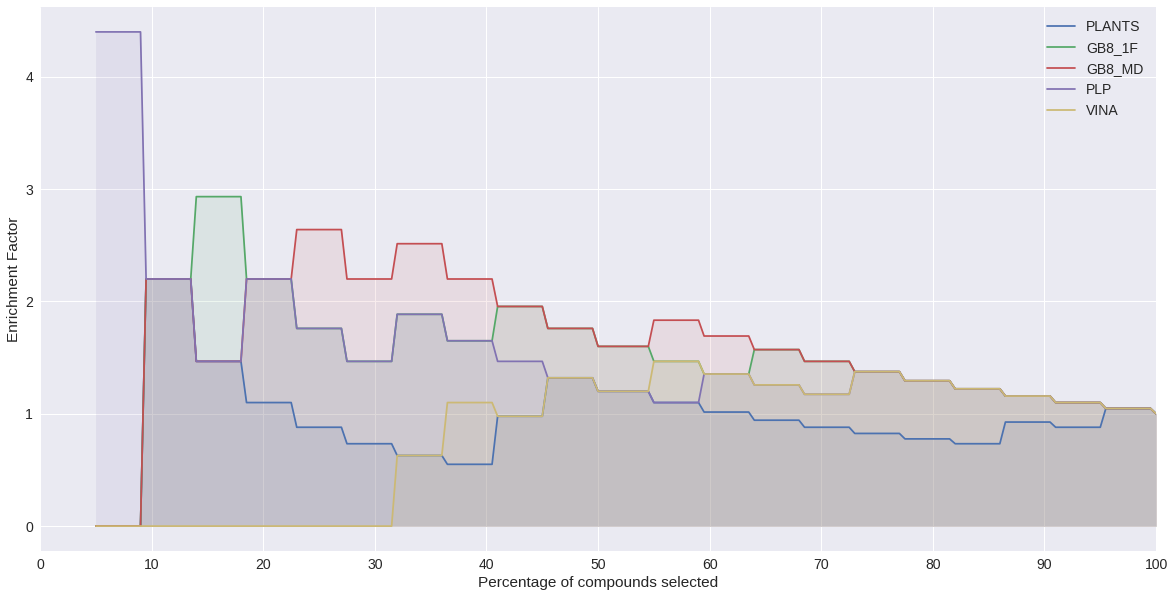

In [26]:
# EF plots
plt.figure(figsize=(20,10))
ax=plt.gca()
for i,method in enumerate(scores_list):
    t = EF.loc[EF['METHOD'] == method]
    t.plot(x='Percentage', y='Enrichment Factor', 
           color=method_color_list[i], ax=ax, label=method)
    ax.fill_between(t['Percentage'], 0, t['Enrichment Factor'], 
                    color=method_color_list[i], alpha=0.1)
ax.set_xticks(np.arange(0,110,10))
plt.xlabel('Percentage of compounds selected')
_=plt.ylabel('Enrichment Factor')
plt.savefig('{}/enrichment_factor.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

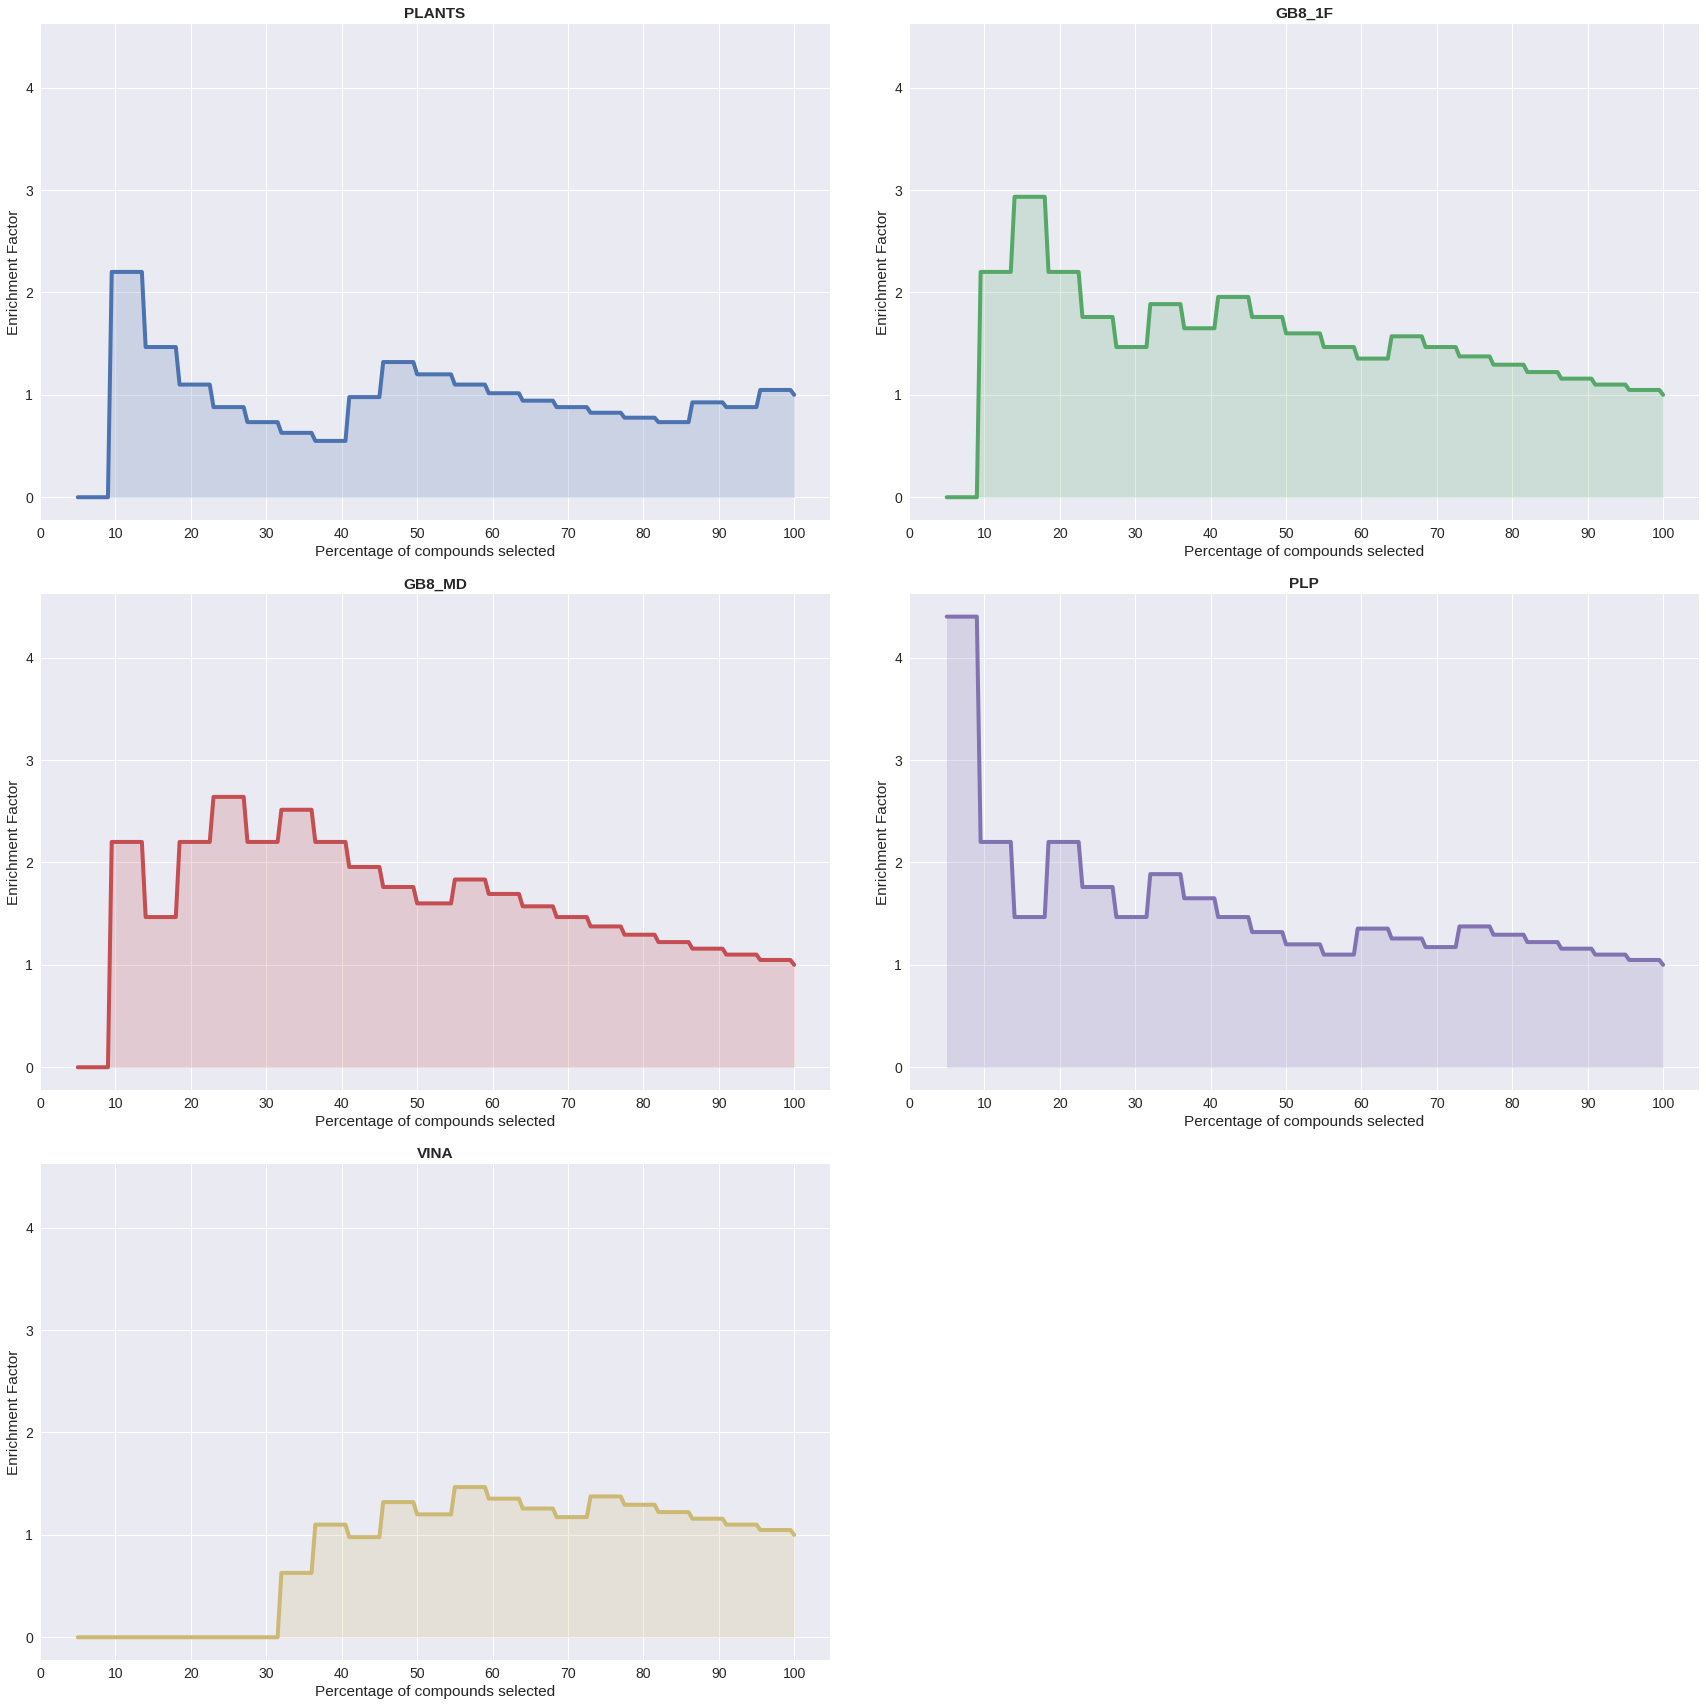

In [27]:
# EF on separated plots
# Fill a column with 0, for plt.fill_between
_EF = EF
_EF['zero'] = 0
g = sns.FacetGrid(data=_EF ,hue='METHOD', hue_order=scores_list, 
                  col='METHOD', col_wrap=2, sharex=True, sharey=True,
                  aspect=1.5, size=8, palette=method_color_list) 
g.map(plt.plot, 'Percentage', 'Enrichment Factor',linewidth=4.0)
g.map(plt.fill_between, 'Percentage', 'zero', 'Enrichment Factor', alpha=0.2)
g.set(xticks=np.arange(0,110,10))
g.set_titles('{col_name}',fontweight='bold')
plt.subplots_adjust(hspace=0.15,wspace=0.1)

for ax in g.axes.flat:
    ax.set_xlabel('Percentage of compounds selected', visible=True)
    ax.set_ylabel('Enrichment Factor', visible=True)
    plt.setp(ax.get_yticklabels(), visible=True)
    _ = plt.setp(ax.get_xticklabels(), visible=True)

plt.savefig('{}/enrichment_factor_grid.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

## ROC curves

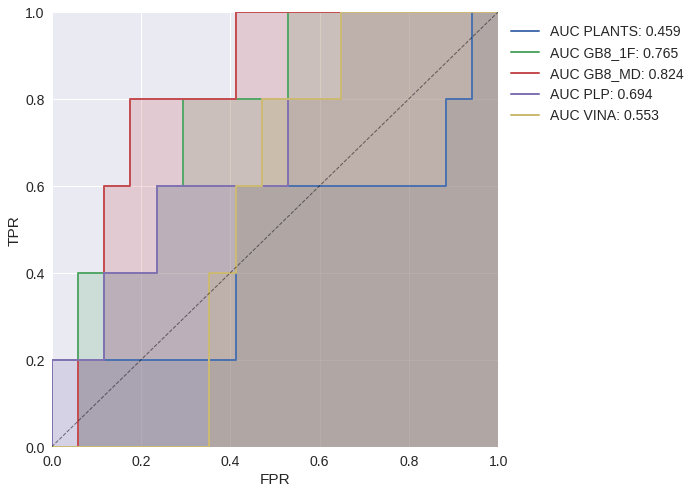

In [28]:
# ROC curves
AUC={}
plt.figure(figsize=(8,8))
ax=plt.gca()
for i,method in enumerate(scores_list):
    temp = ROC.loc[ROC['METHOD'] == method]
    # Compute AUC
    AUC[method] = auc(temp['FPR'], temp['TPR'])
    temp.plot(x='FPR', y='TPR', ax=ax, linewidth=2.0,
              color=method_color_list[i], label='AUC {}: {:.3f}'.format(method,AUC[method]))
    ax.fill_between(temp['FPR'], 0, temp['TPR'], alpha=0.2)

ax.plot((0,1),(0,1), c='k', linestyle='--', linewidth=1.0, alpha=0.5)    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax = plt.gca()
ax.set_xlim([0,1])
_=ax.set_ylim([0,1])
plt.savefig('{}/AUC_ROC.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

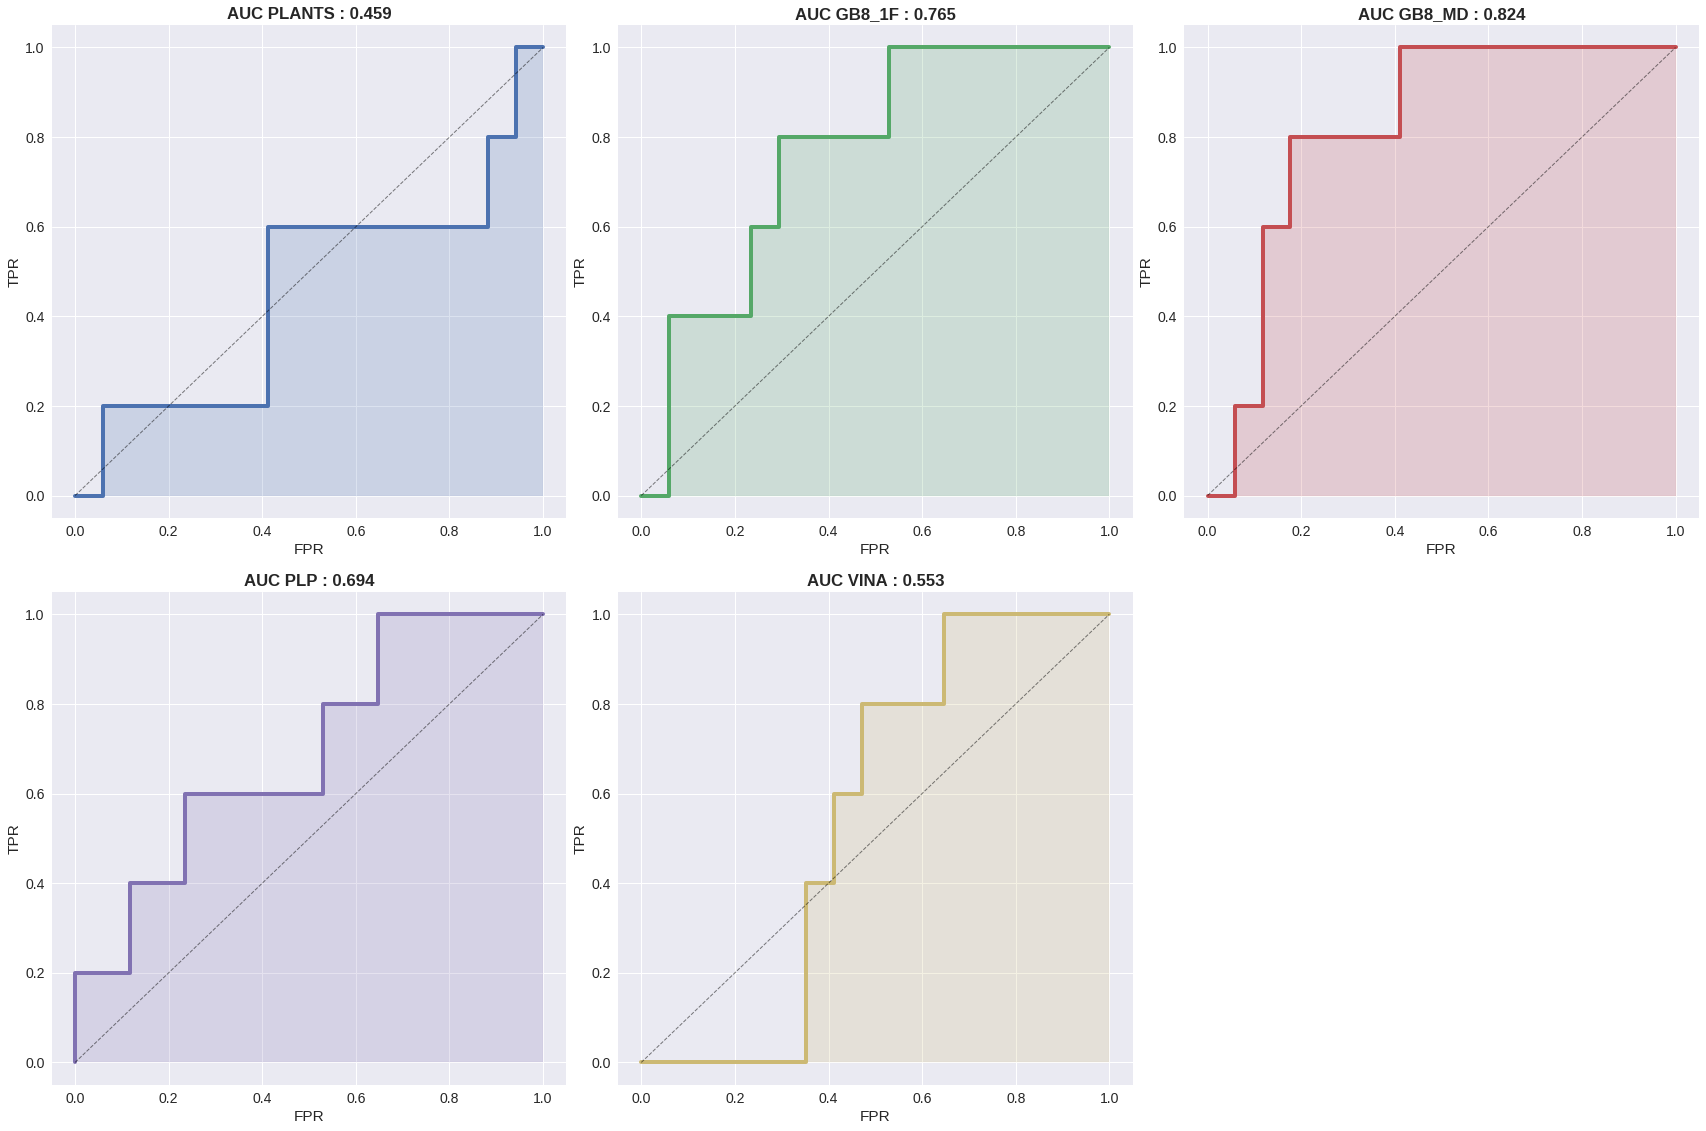

In [29]:
# ROC curves on separated plots
_ROC = ROC
_ROC['zero'] = 0
g = sns.FacetGrid(data=_ROC ,hue='METHOD', hue_order=scores_list, 
                  col='METHOD', col_wrap=3, col_order=scores_list,
                  sharex=True, sharey=True,
                  aspect=1.0, size=8, palette=method_color_list) 
g.map(plt.plot, 'FPR', 'TPR', linewidth=4.0)
g.map(plt.fill_between, 'FPR', 'zero', 'TPR', alpha=0.2)
plt.subplots_adjust(hspace=0.15,wspace=0.1)

for ax,method in zip(g.axes.flat,scores_list):
    ax.plot((0,1),(0,1), c='k', linestyle='--', linewidth=1.0, alpha=0.5)
    ax.set_title('AUC {} : {:.3f}'.format(method,AUC[method]),fontweight='bold')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    plt.setp(ax.get_yticklabels(), visible=True)
    _ = plt.setp(ax.get_xticklabels(), visible=True)

plt.savefig('{}/AUC_ROC_grid.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')